Enable `Matplotlib` magic.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower', interpolation='nearest')

Create `ipyparallel` clients. This also enables a few magic commands for parallel execution.
The documentation of `ipyparallel` is available [here](https://ipyparallel.readthedocs.io/en/latest/). How to setup `ipyparallel` to work with `MPI` is described [here](https://ipyparallel.readthedocs.io/en/latest/process.html#using-ipcluster-in-mpiexec-mpirun-mode).

In [2]:
from ipyparallel import Client
c = Client(profile="mpi")

Convenience functions for visualizing fields and particles

In [3]:
def visualize_field(var):
    
    # Number of clients
    nid = len(c.ids)

    # Create figure
    fig, axes = plt.subplots(nrows=nid, figsize=(6, 7), sharex=True)
    # Remove white space, see http://stackoverflow.com/a/13663328
    plt.setp(axes.flat, aspect=1.0, adjustable='box-forced')

    # Global minimum and maximum of density field
    vmin = min(c[:][var + '.min()'])
    vmax = max(c[:][var + '.max()'])

    # Loop over clients/processors
    for v in c:

        # Axis ID. The order of subplots created by plt.subplots() is "reversed",
        # i.e. the upper-most subplot is axes[0] and the lower-most is axes[len(c.ids) - 1]
        iax = nid - 1 - v['idproc']

        # Axes extent
        extent = [0, v['grid.nx'], v['grid.noff'], v['grid.noff'] + v['grid.nyp']]

        # Plot density from each processor on the corresponding axis
        axes[iax].imshow(v[var], vmin=vmin, vmax=vmax, extent=extent)

        # y-axis label
        axes[iax].set_ylabel('y')

    # x-axis label
    axes[-1].set_xlabel('x')


def visualize_particles(var):
    
    # Number of clients
    nid = len(c.ids)

    # Create figure
    fig, axes = plt.subplots(ncols=nid, figsize=(10, 7), sharey=True)

    # Loop over clients/processors
    for v in c:

        # Axis ID
        iax = v['idproc']
        
        # Plot the particles' y-coordinate vs the particle ID (i.e. array index)
        axes[iax].plot(*zip(*enumerate(v[var + "[:" + var + ".np]['y']"])))

        # Adjust axes limits
        axes[iax].set_xlim(0, v[var + '.np'])
        axes[iax].set_ylim(0, v['grid.ny'])

        # x-axis label
        axes[iax].set_xlabel('Particle ID')

    # y-axis label
    axes[0].set_ylabel('y')

Set various simulation parameters

In [4]:
%%px

# Number of grid points in x- and y-direction
nx, ny = 32, 32

# Average number of particles per cell
npc = 256

# Particle charge and mass
charge = -1.0
mass = 1.0

# Thermal velocity of electrons in x- and y-direction
vtx, vty = 1.0, 1.0
# Drift velocity of electrons in x- and y-direction
vdx, vdy = 0.0, 0.0

# Smoothed particle size
ax, ay = 0.912871, 0.912871

# Time interval between successive calculations
dt = 0.1

Initialize particles' phase space coordinates

In [5]:
%%px

from skeletor import Float
import numpy
from mpi4py import MPI

# Short hand for MPI communicator
comm = MPI.COMM_WORLD

# Synchronize random number generator across ALL processes
numpy.random.set_state(comm.bcast(numpy.random.get_state()))

# Total number of particles in simulation
np = npc*nx*ny

# Uniform distribution of particle positions
x = nx*numpy.random.uniform(size=np).astype(Float)
y = nx*numpy.random.uniform(size=np).astype(Float)
# Normal distribution of particle velocities
vx = vdx + vtx*numpy.random.normal(size=np).astype(Float)
vy = vdy + vty*numpy.random.normal(size=np).astype(Float)

Create particle array on each processor

In [6]:
%%px

from skeletor import cppinit, Grid, Particles

# Start parallel processing
idproc, nvp = cppinit(comm)

# Create numerical grid
grid = Grid(nx, ny, comm)

# Maximum number of electrons in each partition
npmax = int(1.5*np/nvp)

# Create particle array
electrons = Particles(npmax, charge, mass)

# Assign particles to subdomains
electrons.initialize(x, y, vx, vy, grid)

# Make sure the numbers of particles in each subdomain add up to the total
# number of particles
assert comm.allreduce(electrons.np, op=MPI.SUM) == np

Deposit charge on each processor

In [7]:
%%px

from skeletor import Sources

# Initialize sources
sources = Sources(grid, comm, dtype=Float)

# Deposit charge
sources.deposit_ppic2(electrons)

# Make sure the total amount charge deposited on each processor is equal to
# the number of particles on that processor times the particle charge
assert numpy.isclose(sources.rho.sum(), electrons.np*charge)

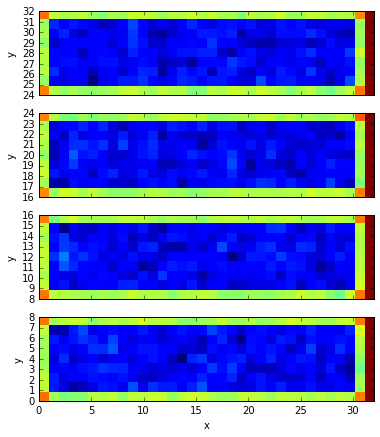

In [8]:
visualize_field('sources.rho')

Add charge from guard cells of neighboring processors. Afterwards erase charge in guard cells.

In [9]:
%%px

# Add charge from guard cells
sources.rho.add_guards_ppic2()

# Make sure that the total amount of charge deposit in the active cells on *all* processors
# is equal to the *total* number of particles times the particle charge
assert numpy.isclose(comm.allreduce(sources.rho.trim().sum(), op=MPI.SUM), np*charge)

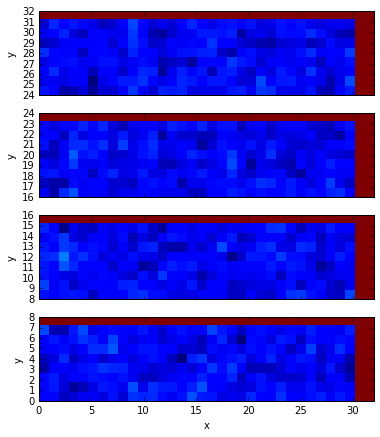

In [10]:
visualize_field('sources.rho')

Compute force field from Gauss' law and push particles

In [11]:
%%px

from skeletor import Field, Float2, Poisson

# Intialize force field
fxy = Field(grid, comm, dtype=Float2)

# Initialize Poisson solver
poisson = Poisson(grid, ax, ay, np)

# Solve Gauss' law
ttp, we = poisson(sources.rho, fxy)
# Apply boundary condition
fxy.copy_guards_ppic2()

# Push particles
ek = electrons.push(fxy, dt)

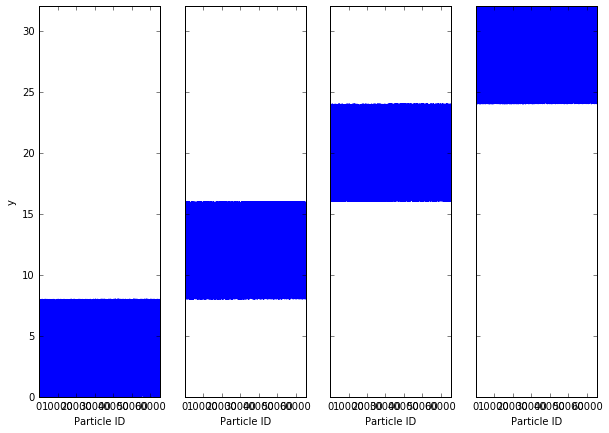

In [12]:
visualize_particles('electrons')

Sort particles according to their y-coordinate

In [13]:
%%px

from skeletor import ParticleSort

# Initialize particle sort
sort = ParticleSort(grid)

# Create a second particle array.
electrons2 = Particles(npmax, charge, mass)

# Sort particles out-of-place according to their cell index in y
sort(electrons, electrons2)

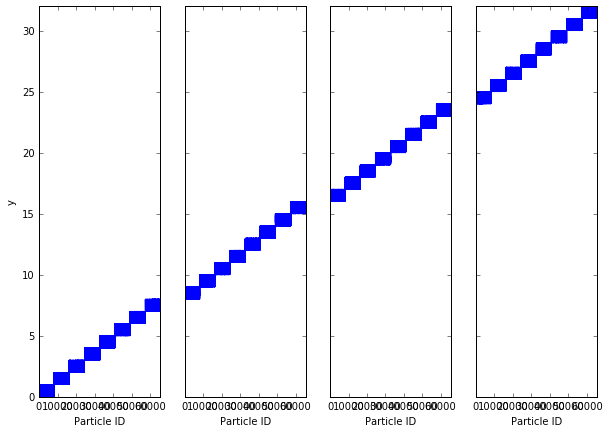

In [14]:
visualize_particles('electrons2')